---
title: "not only averages"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [1]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.ticker as ticker
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
import requests
import json
import os
# %matplotlib widget

In [2]:
#| code-summary: "API to download data from IMS"
# read token from file
with open('../archive/IMS-token.txt', 'r') as file:
    TOKEN = file.readline()
# 28 = SHANI station
STATION_NUM = 28
start = "2022/01/01"
end = "2022/01/07"
filename = 'shani_2022_january.json'

# check if the JSON file already exists
# if so, then load file
if os.path.exists(filename):
    with open(filename, 'r') as json_file:
        data = json.load(json_file)
else:
    # make the API request if the file doesn't exist
    url = f"https://api.ims.gov.il/v1/envista/stations/{STATION_NUM}/data/?from={start}&to={end}"
    headers = {'Authorization': f'ApiToken {TOKEN}'}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text.encode('utf8'))
    
    # save the JSON data to a file
    with open(filename, 'w') as json_file:
        json.dump(data, json_file)
# show data to see if it's alright
# data

In [3]:
#| code-summary: "load data and pre process it"
df = pd.json_normalize(data['data'],record_path=['channels'], meta=['datetime'])
df['date'] = (pd.to_datetime(df['datetime'])
                .dt.tz_localize(None)  # ignores time zone information
             )
df = df.pivot(index='date', columns='name', values='value')
# let's work only with a few days, and only temperature
start = "2022-01-02"
end = "2022-01-05"
df = df.loc[start:end, 'TD'].to_frame()
df.rename(columns={"TD": "temp"}, inplace=True)
# df

In [4]:
#| code-summary: "define functions"
# dirty trick to have dates in the middle of the 24-hour period
# make minor ticks in the middle, put the labels there!
# from https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html

def centered_dates(ax):
    date_form = DateFormatter("%d %b")  # %d 3-letter-Month
    # major ticks at midnight, every day
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    # minor ticks at noon, every day
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[12]))
    # erase major tick labels
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    # set minor tick labels as define above
    ax.xaxis.set_minor_formatter(date_form)
    # completely erase minor ticks, center tick labels
    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

# creating the dictionary with the desired settings
plot_settings = {
    'ylim': [5, 17.5],
    'xlim': [df.index[0], df.index[-1]],
    'ylabel': 'Temperature (°C)',
    'title': 'Yatir Forest, 2022',
    'yticks': [5, 10, 15]
}

Let's see on a graph the average temperature, with an envelope of 1 standard deviation around it:

In [5]:
#| code-fold: false
df['mean'] = df['temp'].rolling('3H', center=True).mean()
df['std'] = df['temp'].rolling('3H', center=True).std()

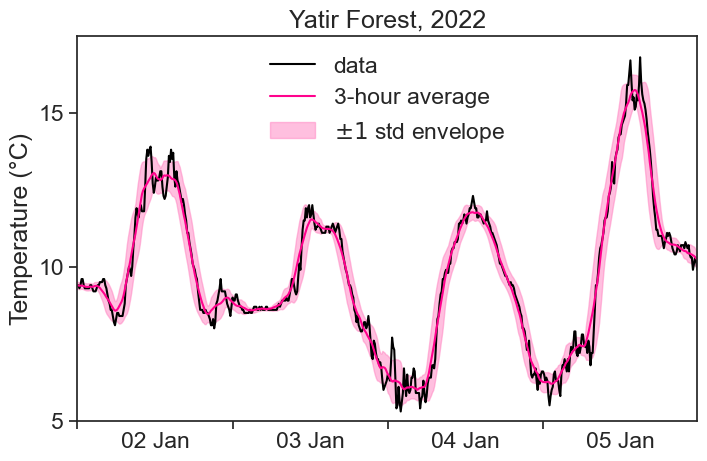

In [6]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8,5))


plot_std = ax.fill_between(df.index,
                            df['mean'] + df['std'],
                            df['mean'] - df['std'],
                            color="xkcd:pink", alpha=0.5)
plot_data, = ax.plot(df['temp'], color='black')
plot_mean, =ax.plot(df['mean'], color='xkcd:hot pink')

ax.legend([plot_data, plot_mean, plot_std],
          ['data', '3-hour average', r"$\pm1$ std envelope"],
          frameon=False)

# applying the settings to the ax object
ax.set(**plot_settings)
centered_dates(ax)
# fig.savefig("YF-temperature_2022_jan.png", dpi=300)

## Confidence Interval

We can calculate anything we want inside the sliding window. One good example is the **Confidence Interval of the Mean**, given by:

$$
CI(\alpha) = Z(\alpha) \cdot SE.
$$

::: {.column-margin}
* $Z(\alpha)=$ Z-score.
* SE $=$ standard error.
:::

$Z(\alpha)$ is the Z-score corresponding to the chosen confidence level $\alpha$. The most commonly used confidence level is 95%, which corresponds to a Z-score of 1.96. What does this mean? This means that we expect to find 95% of the points within $\pm$ 1.96 standard deviations away from the mean.

![](confidence-interval.png)

::: {.column-margin}
Source: [Dhaval Raval's Medium article](https://medium.com/@dhaval.sony.504/know-about-confidence-interval-1f66d9ef7d0f)
:::

You can find the Z-score using the following python code:

In [7]:
#| code-fold: false
from scipy.stats import norm

confidence_level = 0.95
# 5% outside
out = 1 - confidence_level
# 0.975 of points to the left of right boundary
p = 1 - out/2
# inverse of cdf: 0.975 of the points will be smaller than what distance (in sigma units)?
z_score = norm.ppf(p)
print(f"z-score = {z_score}")

z-score = 1.959963984540054


If you are still not convinced why we need 0.975 instead of 0.95, read this [excellent response on
stackoverflow](https://stackoverflow.com/a/20864883).

SE is the standard error:

$$
SE = \frac{\sigma}{ \sqrt{N} }.
$$

::: {.column-margin}
* $\sigma=$ standard deviation.
* $N=$ number of points.
:::

We can write a function to calculate the confidence interval of the mean, and use it with the sliding window:

In [8]:
#| code-fold: false

def std_error_of_the_mean(window):
    return window.std() / np.sqrt(window.count())

def confidence_interval(window):
    return z_score * std_error_of_the_mean(window)

df['std_error'] = df['temp'].rolling('3H', center=True).apply(std_error_of_the_mean)
df['confidence_interval'] = df['temp'].rolling('3H', center=True).apply(confidence_interval)

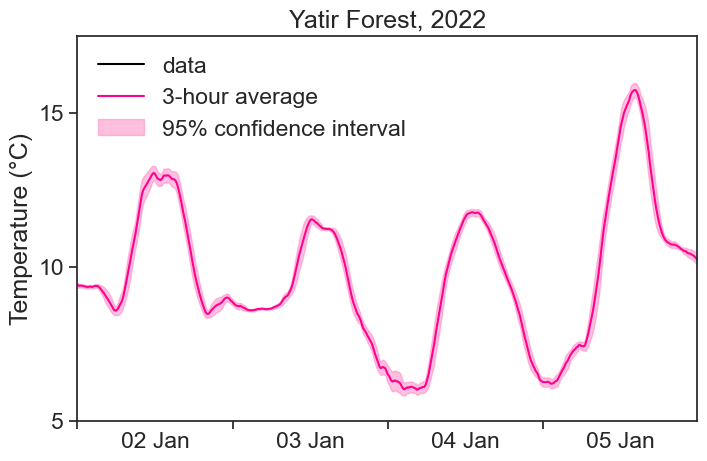

In [11]:
#| code-summary: "plot"
fig, ax = plt.subplots(figsize=(8,5))

plot_std = ax.fill_between(df.index,
                            df['mean'] + df['confidence_interval'],
                            df['mean'] - df['confidence_interval'],
                            color="xkcd:pink", alpha=0.5)
# plot_data, = ax.plot(df['temp'], color='black')
plot_mean, =ax.plot(df['mean'], color='xkcd:hot pink')

ax.legend([plot_data, plot_mean, plot_std],
          ['data', '3-hour average', r"95% confidence interval"],
          frameon=False)

# applying the settings to the ax object
ax.set(**plot_settings)
centered_dates(ax)
# fig.savefig("YF-temperature_2022_jan.png", dpi=300)